In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dogs-vs-cats-redux-kernels-edition/sample_submission.csv
/kaggle/input/dogs-vs-cats-redux-kernels-edition/train.zip
/kaggle/input/dogs-vs-cats-redux-kernels-edition/test.zip


In [4]:
import torchvision
import torch.nn as nn
import torch
import torch.nn.functional as F
from torchvision import transforms,models,datasets
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from torch import optim
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import cv2, glob, numpy as np, pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from glob import glob
!pip install torchsummary
from tqdm import *
from sklearn.model_selection import train_test_split
import os, sys

In [27]:
from torch.utils.data import DataLoader, Dataset
# class cats_dogs(Dataset):
#   def __init__(self, folder):
#     cats = glob(folder+'/cat*')
#     dogs = glob(folder+'/dog*')
#     self.fpaths = cats + dogs
#     from random import shuffle, seed; seed(10); shuffle(self.fpaths)
#     self.targets = [fpath.split('.')[0].split("/")[-1].startswith('dog') for fpath in self.fpaths] # dog=1 & cat=0
#   def __len__(self): return len(self.fpaths)
#   def __getitem__(self, ix):
#     f = self.fpaths[ix]
#     target = self.targets[ix]
#     im = (cv2.imread(f)[:,:,::-1])
#     im = cv2.resize(im, (224,224))
#     return torch.tensor(im/255).permute(2,0,1).to(device).float(), torch.tensor([target]).float().to(device)
class cats_dogs(Dataset):
    def __init__(self, fpaths, transform=None):
        self.fpaths = fpaths
        self.targets = [fpath.split('.')[0].split("/")[-1].startswith('dog') for fpath in self.fpaths]
        self.transform = transform

    def __len__(self):
        return len(self.fpaths)

    def __getitem__(self, ix):
        f = self.fpaths[ix]
        target = self.targets[ix]
        im = cv2.imread(f)[:, :, ::-1]  # Convert BGR to RGB
        im = cv2.resize(im, (224, 224))

        if self.transform:
            im = self.transform(im)

        return torch.tensor(im / 255).permute(2, 0, 1).to(device).float(), torch.tensor([target]).float().to(device)

In [6]:
%%time
train_data_dir = "/kaggle/working/train"
test_data_dir = "/kaggle/working/test"

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 5.72 µs


In [7]:
data = cats_dogs(train_data_dir)
im, label = data[200]

tensor([0.])


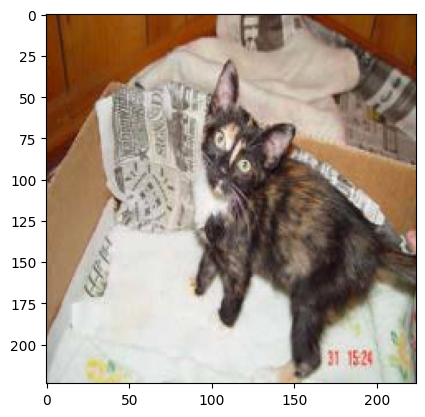

In [8]:
plt.imshow(im.permute(1,2,0).cpu())
print(label)

In [9]:
def conv_layer(ni,no,kernel_size,stride=1):
    return nn.Sequential(
    nn.Conv2d(ni, no, kernel_size, stride),
    nn.ReLU(),
    nn.BatchNorm2d(no),
    nn.MaxPool2d(2)
    )
def get_model():
    model = nn.Sequential(
    conv_layer(3, 64, 3),
    conv_layer(64, 512, 3),
    conv_layer(512, 512, 3),
    conv_layer(512, 512, 3),
    conv_layer(512, 512, 3),
    conv_layer(512, 512, 3),
    nn.Flatten(),
    nn.Linear(512, 1),
    nn.Sigmoid(),
    ).to(device)
    loss_fn = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr= 1e-3)
    return model, loss_fn, optimizer

In [10]:
from torchsummary import summary
model, loss_fn, optimizer = get_model()
summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 222, 222]           1,792
              ReLU-2         [-1, 64, 222, 222]               0
       BatchNorm2d-3         [-1, 64, 222, 222]             128
         MaxPool2d-4         [-1, 64, 111, 111]               0
            Conv2d-5        [-1, 512, 109, 109]         295,424
              ReLU-6        [-1, 512, 109, 109]               0
       BatchNorm2d-7        [-1, 512, 109, 109]           1,024
         MaxPool2d-8          [-1, 512, 54, 54]               0
            Conv2d-9          [-1, 512, 52, 52]       2,359,808
             ReLU-10          [-1, 512, 52, 52]               0
      BatchNorm2d-11          [-1, 512, 52, 52]           1,024
        MaxPool2d-12          [-1, 512, 26, 26]               0
           Conv2d-13          [-1, 512, 24, 24]       2,359,808
             ReLU-14          [-1, 512,

In [11]:
%%time
def train_batch(x, y, model, opt, loss_fn):
    prediction = model(x)
    batch_loss = loss_fn(prediction, y)
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return batch_loss.item()

@torch.no_grad()
def accuracy(x, y, model):
    prediction = model(x)
    is_correct = (prediction > 0.5) == y
    return is_correct.cpu().numpy().tolist()

CPU times: user 46 µs, sys: 14 µs, total: 60 µs
Wall time: 63.7 µs


In [21]:
# glob(train_data_dir+"/*")

In [35]:
%%time
# def get_data():
#     train, val = train_test_split(glob(train_data_dir + "/*"), test_size= 0.2, shuffle = True)
#     trn_dl = DataLoader(cats_dogs(train), batch_size=32, shuffle=True)
#     val_dl = DataLoader(cats_dogs(val), batch_size=32, shuffle=True)
#     return trn_dl, val_dl

def get_data(train_data_dir, batch_size=128):
    all_files = glob(train_data_dir + "/*")
    train_files, val_files = train_test_split(all_files, test_size=0.2, shuffle=True, random_state=42)
    trn_dl = DataLoader(cats_dogs(train_files), batch_size=batch_size, shuffle=True)
    val_dl = DataLoader(cats_dogs(val_files), batch_size=batch_size, shuffle=False)
    return trn_dl, val_dl

CPU times: user 7 µs, sys: 0 ns, total: 7 µs
Wall time: 9.54 µs


In [36]:
@torch.no_grad()
def val_loss(x, y, model):
    prediction = model(x)
    val_loss = loss_fn(prediction, y)
    return val_loss.item()

In [37]:
trn_dl, val_dl = get_data(train_data_dir)
model, loss_fn, optimizer = get_model()

In [ ]:
%%time
from tqdm import tqdm, trange
import numpy as np

train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []

for epoch in trange(5, desc='Epochs'):
    print(f"Epoch {epoch+1}")

    train_epoch_losses, train_epoch_accuracies = [], []
    val_epoch_accuracies = []

    # Training loop with tqdm progress bar
    for ix, batch in enumerate(tqdm(iter(trn_dl), desc='Training Batch', leave=False)):
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)
        train_epoch_losses.append(batch_loss)

    train_epoch_loss = np.array(train_epoch_losses).mean()

    # Accuracy calculation loop for training data
    for ix, batch in enumerate(tqdm(iter(trn_dl), desc='Training Accuracy', leave=False)):
        x, y = batch
        is_correct = accuracy(x, y, model)
        train_epoch_accuracies.extend(is_correct)
    train_epoch_accuracy = np.mean(train_epoch_accuracies)

    # Validation loop with tqdm progress bar
    for ix, batch in enumerate(tqdm(iter(val_dl), desc='Validation Batch', leave=False)):
        x, y = batch
        val_is_correct = accuracy(x, y, model)
        val_epoch_accuracies.extend(val_is_correct)

    val_epoch_accuracy = np.mean(val_epoch_accuracies)

    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_accuracies.append(val_epoch_accuracy)

    # Optionally, print epoch-level summary
    print(f"Epoch {epoch+1} Summary: Training Loss: {train_epoch_loss:.4f}, Training Accuracy: {train_epoch_accuracy:.4f}, Validation Accuracy: {val_epoch_accuracy:.4f}")

Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1



Training Batch:  27%|██▋       | 42/157 [53:00<2:25:34, 75.95s/it]

In [ ]:
# train_losses, train_accuracies = [], []
# val_losses, val_accuracies = [], []
# for epoch in trange(5, desc='Epochs'):

#     print(epoch)
#     train_epoch_losses, train_epoch_accuracies = [], []
#     val_epoch_accuracies = []
#     for ix, batch in enumerate(iter(trn_dl)):
#         #print(ix)
#         x, y = batch
#         batch_loss = train_batch(x, y, model, optimizer, loss_fn)
#         train_epoch_losses.append(batch_loss)
#     train_epoch_loss = np.array(train_epoch_losses).mean()

#     for ix, batch in enumerate(iter(trn_dl)):
#         x, y = batch
#         is_correct = accuracy(x, y, model)
#         train_epoch_accuracies.extend(is_correct)
#     train_epoch_accuracy = np.mean(train_epoch_accuracies)

#     for ix, batch in enumerate(iter(val_dl)):
#         x, y = batch
#         val_is_correct = accuracy(x, y, model)
#         val_epoch_accuracies.extend(val_is_correct)
#         #validation_loss = val_loss(x, y, model)
#     val_epoch_accuracy = np.mean(val_epoch_accuracies)

#     train_losses.append(train_epoch_loss)
#     train_accuracies.append(train_epoch_accuracy)
#     #val_losses.append(validation_loss)
#     val_accuracies.append(val_epoch_accuracy)

In [ ]:
epochs = np.arange(5)+1
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline
plt.plot(epochs, train_accuracies, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracies, 'r', label='Validation accuracy')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation accuracy with 4K data points used for training')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
#plt.ylim(0.8,1)
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])
plt.legend()
plt.grid('off')
plt.show()

In [ ]:
torch.save(model, 'cnn_model.pth')
# Later, to load the entire model
model = torch.load('cnn_model.pth')

for the model prediction:

In [ ]:
prediction = []
# List of image paths
# Process and predict for each image
class cats_dogs_prediction(Dataset):
    def __init__(self, fpaths, transform=None):
        self.fpaths = fpaths
        self.transform = transform

    def __len__(self):
        return len(self.fpaths)

    def __getitem__(self, ix):
        f = self.fpaths[ix]
        im = cv2.imread(f)[:, :, ::-1]  # Convert BGR to RGB
        im = cv2.resize(im, (224, 224))

        if self.transform:
            im = self.transform(im)

        return torch.tensor(im / 255).permute(2, 0, 1).to(device).float()

def get_data_prediction():
    all_files = glob(test_data_dir + "/*")
    trn_dl = DataLoader(cats_dogs(all_files), shuffle=False)
    return trn_dl

In [ ]:
@torch.no_grad()
def predict_cnn(x, model):
    model.eval()
    prediction = model(x)
    return prediction
prediction = predict_cnn(get_data_prediction(), model)

In [ ]:
pd.DataFrame({
    "id" : pd.Series(np.arange(1,12501)),
    "label" : prediction
}).to_csv("cnn_submission.csv", sep = ",")